In [2]:
import SimpleITK as sitk
import pandas as pd
from IPython.display import display, HTML 
 
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

In [3]:
img = sitk.ReadImage( "/scratch/blowekamp/data/130205_BSubtilis1-a.mrc")
# Chop off first slices before scope got stable
img = img[:,:,10:]

In [4]:
median_img = sitk.Rank(img, 0.5, radius=[2,2,1])
simg = sitk.Shrink(median_img, [3,3,1])

In [5]:
# segment mostly background by thresholding, then invert to forground
cc_img = sitk.ConnectedComponent((simg<120)-(simg==0))
cc_img = sitk.RelabelComponent(cc_img)!=1

In [6]:
# remove small islands and wholes, leaving final foreground
ccc = sitk.BinaryClosingByReconstruction(cc_img, [10,10,10])
ccc = sitk.BinaryOpeningByReconstruction(ccc, [10,10,10])
ccc -= (simg==0)

In [7]:
dist_img = sitk.SignedMaurerDistanceMap(ccc != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
radius = 10
seeds = sitk.ConnectedComponent(dist_img < -radius)
ws = sitk.MorphologicalWatershedFromMarkers(dist_img, seeds, markWatershedLine=True)
ws = sitk.Mask( ws, sitk.Cast(ccc, ws.GetPixelID()))

In [8]:
bgp = sitk.BinaryGrindPeak( (ws!=0)|(simg==0) )
non_boarder_seg = sitk.Mask( ws, bgp==0)

In [10]:
sitk.WriteImage(sitk.LabelOverlay( simg[:,:,123],non_boarder_seg[:,:,123]), "temp/segmentation.tif")

In [23]:
shapeStats = sitk.LabelShapeStatisticsImageFilter()
shapeStats.Execute(non_boarder_seg) # Why does this not work with the labelMap?

In [12]:
statsList = [ (shapeStats.GetPhysicalSize(i),
               shapeStats.GetElongation(i),
               shapeStats.GetFlatness(i),
               shapeStats.GetPrincipalMoments(i)[0],
               shapeStats.GetPrincipalMoments(i)[1],
               shapeStats.GetPrincipalMoments(i)[2]) for i in shapeStats.GetLabels()]
cols=["Volume (nm^3)", "Elongation", "Flatness", "First Principal Moment (nm)","Second Principal Moment (nm)", "Third Principal Moment (nm)" ]
stats = pd.DataFrame(data=statsList, index=shapeStats.GetLabels(), columns=cols)
 

In [13]:
stats.describe()

,Volume (nm^3),Elongation,Flatness,First Principal Moment (nm),Second Principal Moment (nm),Third Principal Moment (nm)
count,4.700000e+01,47.000000,47.000000,47.000000,47.000000,47.000000
mean,1.158468e+09,2.312976,1.311093,39013.948689,47910.672115,308432.959457
std,5.029677e+08,0.696173,0.953388,16089.102701,19242.293646,154199.534094
min,1.843830e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.001609e+09,2.134413,1.075242,38092.782834,46848.866810,237721.504132
50%,1.333639e+09,2.459576,1.114562,43603.019925,54242.882755,320552.631075
75%,1.450556e+09,2.735423,1.146932,47637.392827,57866.587679,407410.430803
max,1.875608e+09,3.423493,5.460449,56292.679699,69716.451034,612021.522334


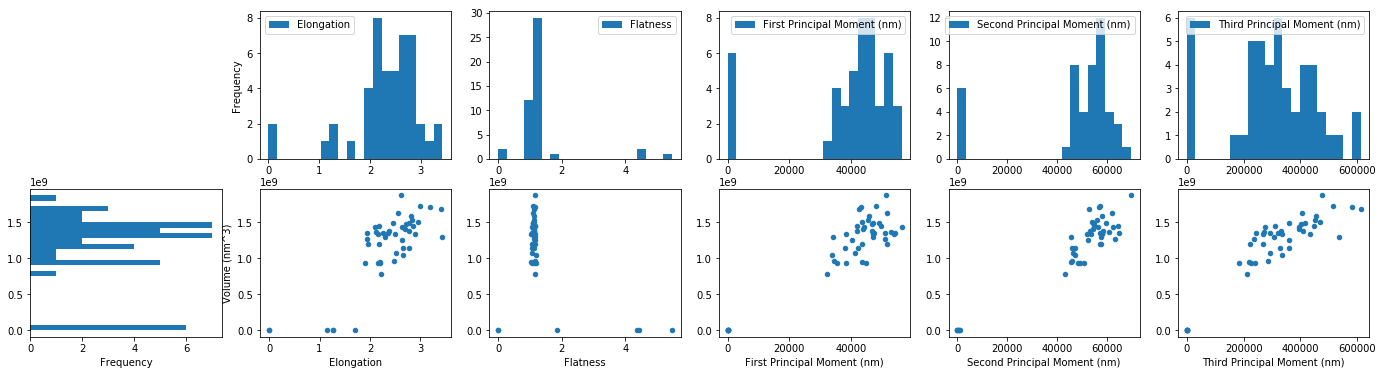

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=len(cols), figsize=(4*len(cols),6))
axes[0,0].axis('off')
 
stats.loc[:,cols[0]].plot.hist(ax=axes[1,0],orientation='horizontal', bins=25)
axes[1,0].yaxis.set_label_position("left")
 
for i in range(1,len(cols)):
    c = cols[i]
    stats.loc[:,[c]].plot.hist(ax=axes[0,i], bins=20)
    scatter = stats.plot.scatter(ax=axes[1,i],x=c,y=cols[0])
    if (i != 1):
        axes[0,i].set_ylabel("")
        axes[1,i].set_ylabel("")
 

In [31]:
stats.sort_values(by=["Volume (nm^3)"], ascending=True)

,Volume (nm^3),Elongation,Flatness,First Principal Moment (nm),Second Principal Moment (nm),Third Principal Moment (nm)
166,1.843830e+03,0.000000,0.000000,0.000000,0.000000,0.000000
202,3.687660e+03,0.000000,0.000000,0.000000,0.000000,36.004403
160,9.219150e+03,1.701539,1.837665,8.702100,29.387110,85.082600
128,1.530379e+05,1.151941,5.460449,22.902008,682.857774,906.130455
122,1.770077e+05,1.262585,4.370881,33.071505,631.817881,1007.194466
127,2.507609e+05,1.260876,4.440931,51.087660,1007.543902,1601.802719
81,7.796819e+08,2.227849,1.154756,32279.807650,43043.854008,213639.977723
174,9.276161e+08,1.897260,1.065587,44653.156881,50702.602685,182508.858718
115,9.303487e+08,2.202291,1.180216,35466.241352,49401.241905,239600.151316
143,9.349711e+08,2.157175,1.122822,38436.503809,48457.997151,225494.552751


In [24]:
labelMap = sitk.LabelImageToLabelMap(non_boarder_seg)

In [33]:
out = sitk.ChangeLabelLabelMap(labelMap, {166:0})

In [34]:
{ l : 0 for l in 

LabelMap (0x8e9adb0)
  RTTI typeinfo:   itk::LabelMap<itk::LabelObject<unsigned int, 3u> >
  Reference Count: 1
  Modified Time: 6577159
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 6577101
  UpdateMTime: 6577158
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [1243, 698, 238]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [1243, 698, 238]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [1243, 698, 238]
  Spacing: [12.0007, 12.0007, 12.8028]
  Origin: [680.042, -133.259, 128.028]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
12.0007 0 0
0 12.0007 0
0 0 12.8028

  PointToIndexMatrix: 
0.0833282 0 0
0 0.0833282 0
0 0 0.0781079

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  BackgroundValue: 0
  LabelObjectContainer: 0x8e9b030

